# Attribution Demo 

<a target="_blank" href="https://colab.research.google.com/github/safety-research/circuit-tracer/blob/main/demos/attribute_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In this demo, you'll learn how to load models and perform attribution on them.

In [1]:
#@title Colab Setup Environment

try:
    import google.colab
    !mkdir -p repository && cd repository && \
     git clone https://github.com/safety-research/circuit-tracer && \
     curl -LsSf https://astral.sh/uv/install.sh | sh && \
     uv pip install -e circuit-tracer/

    import sys
    from huggingface_hub import notebook_login
    sys.path.append('repository/circuit-tracer')
    sys.path.append('repository/circuit-tracer/demos')
    notebook_login(new_session=False)
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    # import sys
    # sys.path.insert(0, "/home/tu/circuit-tracer/circuit_tracer")

In [2]:
from pathlib import Path
import torch

from circuit_tracer import ReplacementModel, attribute
from circuit_tracer.utils.create_graph_files import create_graph_files, create_graph_files_topk, create_graph_files_edge_weights    
from circuit_tracer.graph import Graph, prune_graph, compute_graph_scores
from circuit_tracer.subgraph.prune import prune_graph_topk, prune_graph_edge_weights
from circuit_tracer.subgraph.clustering import compute_invalid_merge_pairs, hierarchical_cluster_from_invalid

First, load your model and transcoders by name. `model_name` is a normal HuggingFace / [TransformerLens](https://github.com/TransformerLensOrg/TransformerLens) model name; we'll use `google/gemma-2-2b`. We set `transcoder_name` to `gemma`, which is shorthand for the [Gemma Scope](https://arxiv.org/abs/2408.05147) transcoders; we take the transcoders with lowest L0 (mean # of active features) for each layer.

We additionally support `model_name = "meta-llama/Llama-3.2-1B"`, with `"llama"` transcoders; these are ReLU skip-transcoders that we trained, available [here](https://huggingface.co/mntss/skip-transcoder-Llama-3.2-1B-131k-nobos/tree/new-training).

If you want to use other models, you'll have to provide your own transcoders. To do this, set `transcoder_name` to point to your own configuration file, specifying the list of transcoders that you want to use. You can see `circuit_tracer/configs` for example configs.

In [ ]:
from huggingface_hub import login

login(token="")

In [3]:
model_name = 'google/gemma-2-2b'
transcoder_name = "gemma" #"gemma" mntss/clt-gemma-2-2b-426k
model = ReplacementModel.from_pretrained(model_name, transcoder_name, dtype=torch.bfloat16)

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer


Next, set your attribution arguments.

In [4]:
prompt = "Fact: The capital of state containing Dallas is"  # What you want to get the graph for
max_n_logits = 10   # How many logits to attribute from, max. We attribute to min(max_n_logits, n_logits_to_reach_desired_log_prob); see below for the latter
desired_logit_prob = 0.95  # Attribution will attribute from the minimum number of logits needed to reach this probability mass (or max_n_logits, whichever is lower)
max_feature_nodes = 8192  # Only attribute from this number of feature nodes, max. Lower is faster, but you will lose more of the graph. None means no limit.
batch_size=256  # Batch size when attributing
offload='disk' if IN_COLAB else 'cpu' # Offload various parts of the model during attribution to save memory. Can be 'disk', 'cpu', or None (keep on GPU)
verbose = True  # Whether to display a tqdm progress bar and timing report

Then, just run attribution!

In [10]:
graph = attribute(
    prompt=prompt,
    model=model,
    max_n_logits=max_n_logits,
    desired_logit_prob=desired_logit_prob,
    batch_size=batch_size,
    max_feature_nodes=max_feature_nodes,
    offload=offload,
    verbose=verbose
)

Phase 0: Precomputing activations and vectors
Precomputation completed in 0.51s
Found 8296 active features
Phase 1: Running forward pass
Forward pass completed in 0.09s
Phase 2: Building input vectors
Selected 10 logits with cumulative probability 0.7148
Will include 8192 of 8296 feature nodes
Input vectors built in 1.81s
Phase 3: Computing logit attributions
<sys>:0: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
Logit attributions completed in 0.08s
Phase 4: Computing feature attributions
Feature influence computation: 100%|██████████| 8192/8192 [00:01<00:00, 4368.04it/s]
Feature attributions completed in 1.88s
Attribution completed in 9.61s


We now have a graph object! We can save it as a .pt file, but be warned that it's large (~167MB).

In [5]:
graph_dir = 'graphs'
graph_name = 'austin.pt'
graph_dir = Path(graph_dir)
graph_dir.mkdir(exist_ok=True)
graph_path = graph_dir / graph_name

# graph.to_pt(graph_path)

In [23]:
graph = Graph.from_pt(graph_path)
node_mask, edge_mask, cumulative_scores = prune_graph_topk(graph, top_k = 3)
# node_mask, edge_mask, cumulative_scores = prune_graph_edge_weights(graph, edge_weight_threshold=3)
print(edge_mask.sum(), node_mask.sum(), cumulative_scores)

tensor(33) tensor(18) tensor([0.7679, 0.7670, 0.7059,  ..., 1.0000, 1.0000, 1.0000])


In [24]:
results = hierarchical_cluster_from_invalid(graph, *compute_invalid_merge_pairs(graph, node_mask, edge_mask), edge_mask=edge_mask, num_clusters=10)
print(results)

[{474, 677, 6942}, {7267, 1118}, {1527}, {1904}, {2497, 7159}, {5006}, {6906}, {7479}, {8452}, {8456}, {8457}, {8458}, {8460}, {8462}]


In [25]:
# Print out all nodes, and if a node is a Feature, print its active feature details.

# Print out all nodes, and if a node is a Feature, print its active feature details.

n_features = len(graph.selected_features)         # first set of nodes: feature nodes
n_token = len(graph.input_tokens)                # token nodes count
n_error = graph.cfg.n_layers * n_token            # error nodes count

node_attrs = {}
for orig_idx in torch.where(node_mask)[0].tolist():
    if orig_idx < n_features:
        node_type = "Feature"
        data = tuple(graph.active_features[orig_idx].tolist())
    elif orig_idx < n_features + n_error:
        node_type = "Error"
        data = None
    elif orig_idx < n_features + n_error + n_token:
        node_type = "Token"
        data = None
    else:
        node_type = "Logit"
        data = None
    node_attrs[orig_idx] = {"type": node_type, "data": data}

for node in torch.where(node_mask)[0].tolist():
    node_type = node_attrs[node]["type"]
    print(f"Node {node}: {node_type}, Degree: {edge_mask[node].sum().item()}")
    if node_type == "Feature":
        print("  Active feature:", graph.active_features[node])
    elif node_type == "Token":
        print("  Token:", node - n_features - n_error)

Node 474: Feature, Degree: 3
  Active feature: tensor([   0,    6, 7750])
Node 677: Feature, Degree: 3
  Active feature: tensor([   0,    8, 5626])
Node 1118: Feature, Degree: 3
  Active feature: tensor([   1,    8, 4767])
Node 1527: Feature, Degree: 3
  Active feature: tensor([   2,    8, 9457])
Node 1904: Feature, Degree: 3
  Active feature: tensor([   3,    8, 5892])
Node 2497: Feature, Degree: 3
  Active feature: tensor([    4,     8, 13154])
Node 5006: Feature, Degree: 2
  Active feature: tensor([   7,    8, 6861])
Node 6906: Feature, Degree: 3
  Active feature: tensor([  14,    8, 2268])
Node 6942: Feature, Degree: 1
  Active feature: tensor([  15,    4, 4494])
Node 7159: Feature, Degree: 2
  Active feature: tensor([  17,    9, 7178])
Node 7267: Feature, Degree: 2
  Active feature: tensor([  18,    9, 8959])
Node 7479: Feature, Degree: 3
  Active feature: tensor([   20,     9, 15589])
Node 8452: Token, Degree: 0
  Token: 0
Node 8456: Token, Degree: 0
  Token: 4
Node 8457: Token, 

Given this object, we can create the graph files that we need to visualize the graph. Give it a slug (name), and set the node / edge thresholds for pruning. Pruning removes unimportant nodes and edges from your graph; lower thresholds (i.e., more aggressive pruning) results in smaller graphs. These may be easier to interpret, but explain less of the model's behavior.

In [6]:
slug = "dallas-austin"  # this is the name that you assign to the graph
graph_file_dir = './graph_files'  # where to write the graph files. no need to make this one; create_graph_files does that for you
node_threshold=0.8  # keep only the minimum # of nodes whose cumulative influence is >= 0.8
edge_threshold=0.98  # keep only the minimum # of edges whose cumulative influence is >= 0.98

create_graph_files(
    graph_or_path=graph_path,  # the graph to create files for
    slug=slug,
    output_path=graph_file_dir,
    node_threshold=node_threshold,
    edge_threshold=edge_threshold
)

# create_graph_files_topk(
#     graph_or_path=graph_path,  # the graph to create files for
#     slug=slug,
#     output_path=graph_file_dir,
#     top_k=3
# )

# create_graph_files_edge_weights(
#     graph_or_path=graph_path,  # the graph to create files for
#     slug=slug,
#     output_path=graph_file_dir,
#     edge_weight_threshold=3
# )

Now, you can visualize the graph using the following commands! This will spin up a local server to act as the frontend.

**If you're running this notebook on a remote server, make sure that you set up port forwarding, so that the chosen port is accessible on your local machine too.**

You can select nodes by clicking on them. Ctrl/Cmd+Click on nodes to pin and unpin them to your subgraph. G+Click on nodes in the subgraph to group them together into a supernode; G+Click on the X next to a supernode to dissolve it. Click on the edit button to edit node descriptions, and click on supernode description to edit that.

In [4]:
from circuit_tracer.frontend.local_server import serve

port = 8046
server = serve(data_dir='./graph_files/', port=port)

if IN_COLAB:
    from google.colab import output as colab_output  # noqa
    colab_output.serve_kernel_port_as_iframe(port, path='/index.html', height='800px', cache_in_notebook=True)
else:
    from IPython.display import IFrame
    print(f"Use the IFrame below, or open your graph here: f'http://localhost:{port}/index.html'")
    # display(IFrame(src=f'http://localhost:{port}/index.html', width='100%', height='800px'))


OSError: [Errno 98] Address already in use

In [11]:
display(IFrame(src=f'http://localhost:{port}/index.html', width='100%', height='800px'))

Once you're done, you can stop the server with the following command.

In [11]:
server.stop()

NameError: name 'server' is not defined

Congrats, you're done! Go to `intervention_demo.ipynb` to see how to perform interventions, or check out `gemma_demo.ipynb` and `llama_demo.ipynb` for examples of worked-out test examples. Read on for a bit more info aabout the Graph class and pruning.

## Graphs

Earlier, you created a graph object. Its adjacency matrix / edge weights are stored in `graph.adjacency_matrix` in a dense format; rows are target nodes and columns are source nodes. The first `len(graph.real_features)` entries of the matrix represent features; the `i`th entry corresponds to the `i`th feature in `graph.real_features`, given in `(layer, position, feature_idx)` format. The next `graph.cfg.n_layers * graph.n_pos` entries are error_nodes. The next `graph.n_pos` entries are token nodes. The final `len(graph.logit_tokens)` entries are logit nodes.

The value of the cell `graph.adjacency_matrix[target, source]` is the direct effect of the source node on the target node. That is, it tells you how much the target node's value would change if the source node were set to 0, while holding the attention patterns, layernorm denominators, and other feature activations constatnt. Thus, if the target node is a feature, this tells you how much the target feature would change; if the target node is a logit, this tells you how much the (de-meaned) value of the logit would change.

Note that `gemma-2-2b` is model (family) that uses logit softcapping. This means that a softcap function, `softcap(x) = t * tanh(x/t)` is used to constrain the logits to fall within (-t, t); `gemma-2-2b` uses `t=30`. For such models, we predict the change in logits *pre-softcap*, as the nonlinearity introduced by softcapping would cause our attribution to yield incorrect / approximate direct effect values.

### Pruning
Given a graph, you might want to prune it, as it will otherwise contain many low-impact nodes and edges that clutter the circuit diagram while adding little information. We enable you to prune nodes by absolute influence, i.e. the total impact that the nodes have on the logits, direct and indirect. The default threshold is 0.8: this means we will keep the minimum number of nodes required to capture 80% of all logit effects. Similarly, the edge_threshold, by default 0.98, means that we will keep the minimum number of edges required to capture 98% of all logit effects.

# Visualization

In [14]:
from circuit_tracer.subgraph.clustering import hierarchical_cluster_from_invalid, compute_invalid_merge_pairs

invalid_merge_pairs, valid_nodes = compute_invalid_merge_pairs(graph, node_mask, edge_mask)
clusters = hierarchical_cluster_from_invalid(
    graph, invalid_merge_pairs, valid_nodes, edge_mask=edge_mask, num_clusters=10
)

In [20]:
from graph_visualization import create_graph_visualization, Supernode, InterventionGraph

supernodes = []
for i, cluster in enumerate(clusters):
    name = f"Cluster {i}"
    # Optionally, you could store additional info from the cluster in 'features'
    sn = Supernode(name=name, features=[graph.active_features[idx].tolist() for idx in cluster if idx < len(graph.active_features)])
    supernodes.append(sn)

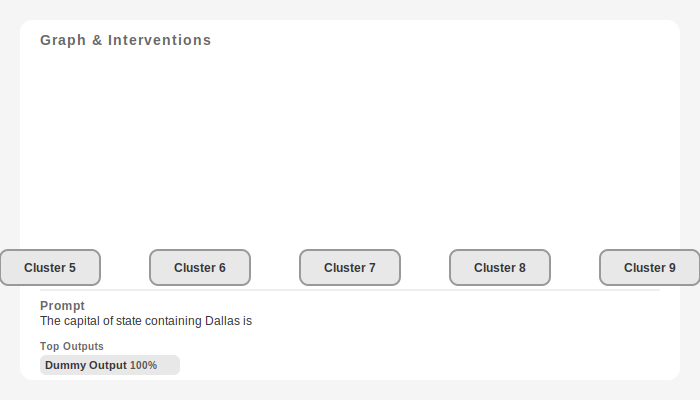

In [21]:
ordered_nodes = [supernodes]

# Create an InterventionGraph object with a prompt describing the clustering
# prompt = "Hierarchical Clustering Visualization of the Attribution Graph"
intervention_graph = InterventionGraph(ordered_nodes=ordered_nodes, prompt=prompt)

# For demonstration, define dummy top outputs (you can replace these with model outputs)
top_outputs = [("Dummy Output", 1.0)]

# Visualize the intervention graph (this uses the SVG-based visualization)
display(create_graph_visualization(intervention_graph, top_outputs))